# PySDD: SDD Python Wrapper

*Wannes Meert (KU Leuven), Arthur Choi (UCLA) - 2018*

In [2]:
import os, sys
sys.path.append(os.pardir)

In [3]:
from pysdd.sdd import Vtree, SddManager, WmcManager, Fnf

In [4]:
from array import array
from pathlib import Path
from graphviz import Source
import math

## Vtree

In [4]:
vtree = Vtree(4)

In [5]:
print("Size: {}".format(vtree.size()))

Size: 0


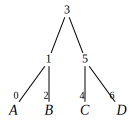

In [6]:
Source(vtree.dot())

## SDD Manager

Ask for documentation:

In [7]:
SddManager?

Create new manager with four variables A, B, C, and D

In [8]:
mgr = SddManager(var_count=4)
a, b, c, d = [mgr.literal(i) for i in range(1,5)]
str(a)

'SddNode(1)'

A negative literal can be obtained by negating a positive literal or negating the numeric representation of a literal.

In [9]:
str(-mgr.literal(1)), str(mgr.literal(-1))

('SddNode(-1)', 'SddNode(-1)')

In [10]:
mgr.is_var_used(-2)

0

Create the formula $(A \land B) \lor (C \land D)$

In [11]:
fab   = mgr.conjoin(a, b)
fcd   = mgr.conjoin(c, d)
fabcd = mgr.disjoin(fab, fcd)
str(fcd)

'SddNode(Decision)'

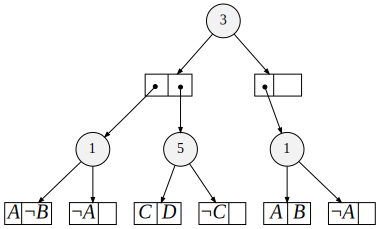

In [12]:
Source(fabcd.dot())

Use shorter syntax by mapping and/or to */+

In [13]:
mgr = SddManager(var_count=4)
a, b, c, d = [mgr.literal(i) for i in range(1,5)]

 sdd size       : 8
 sdd node count : 4


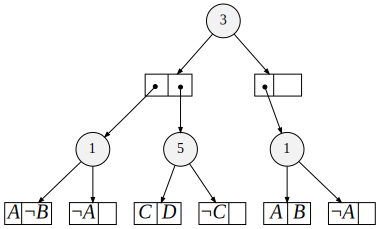

In [14]:
fabcd = (a*b) + (c*d)
print(f" sdd size       : {fabcd.size()}")
print(f" sdd node count : {fabcd.count()}")
Source(fabcd.dot())

Which can be minimized using:

In [15]:
fabcd.ref()
mgr.minimize_limited()
print(f" sdd size       : {fabcd.size()}")
print(f" sdd node count : {fabcd.count()}")
Source(fabcd.dot())
fabcd.deref()

 sdd size       : 6
 sdd node count : 3


Or we can minimize cardinality

 sdd size       : 10
 sdd node count : 5


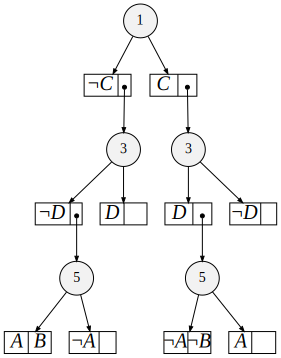

In [16]:
fabcd = mgr.global_minimize_cardinality(fabcd)
print(f" sdd size       : {fabcd.size()}")
print(f" sdd node count : {fabcd.count()}")
Source(fabcd.dot())

## Examples

### Example: API documentation example 1

In [17]:
var_count = 4
var_order = array("l", [2,1,4,3])
tree_type = "balanced"

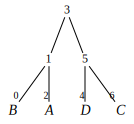

In [18]:
vtree = Vtree(var_count=var_count, var_order=var_order, vtree_type=tree_type.encode())
Source(vtree.dot())

In [19]:
mgr = SddManager(vtree=vtree)

construct a formula $(A \land B) \lor (B \land C) \lor (C \land D)$

In [20]:
f_a = mgr.literal(1)
f_b = mgr.literal(2)
f_c = mgr.literal(3)
f_d = mgr.literal(4)

In [21]:
str(f_a)

'SddNode(1)'

In [22]:
alpha = mgr.false()

In [23]:
beta  = mgr.conjoin(f_a,f_b)
alpha = mgr.disjoin(alpha,beta)
beta  = mgr.conjoin(f_b,f_c)

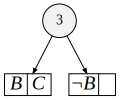

In [24]:
Source(mgr.dot(beta))

In [25]:
alpha = mgr.disjoin(alpha,beta)
beta  = mgr.conjoin(f_c,f_d)
alpha = mgr.disjoin(alpha,beta)

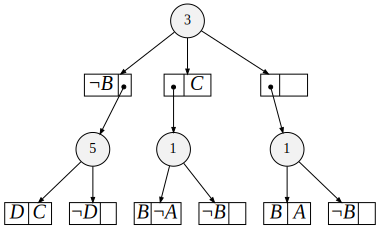

In [26]:
Source(alpha.dot())

### Example: Load from CNF file

In [5]:
cnf_str = """p cnf 6 3
1 4 0
-1 2 5 0
-1 -2 3 6 0
"""
mgr, f = SddManager.from_cnf_string(cnf_str)

Read CNF: vars=6 clauses=3


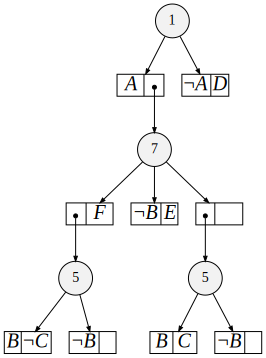

In [8]:
Source(f.dot())

#### Change the SDD after loading the CNF

In [9]:
print(f"Var count before: {mgr.var_count()}")
mgr.add_var_after_last()
mgr.add_var_after_last()
print(f"Var count after:  {mgr.var_count()}")

Var count before: 6
Var count after:  8


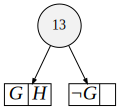

In [10]:
g = mgr.literal(7)
h = mgr.literal(8)

fp = mgr.conjoin(g, h)
Source(fp.dot())

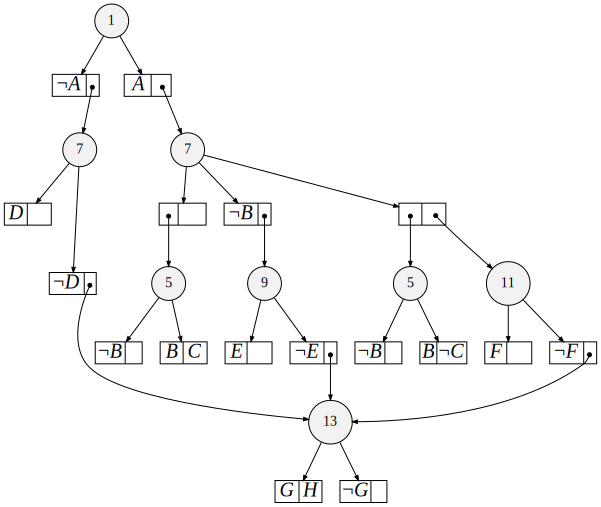

In [11]:
fpp = mgr.disjoin(f, fp)
Source(fpp.dot())

### Example: API documentation example 6

In [10]:
vtree_path = Path("../examples/input/opt-swap.vtree")
if not vtree_path.exists():
    print(f"File not found: {vtree_path}")
sdd_path = Path("../examples/input/opt-swap.sdd")
if not sdd_path.exists():
    print(f"File not found: {sdd_path}")

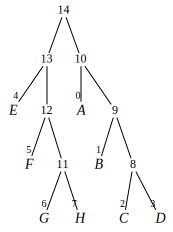

In [11]:
vtree = Vtree(filename=bytes(vtree_path))    
Source(vtree.dot())

In [13]:
mgr = SddManager.from_vtree(vtree)
alpha = mgr.read_sdd_file(bytes(sdd_path))
print(f"Size alpha: {alpha.size()}")

Size alpha: 116


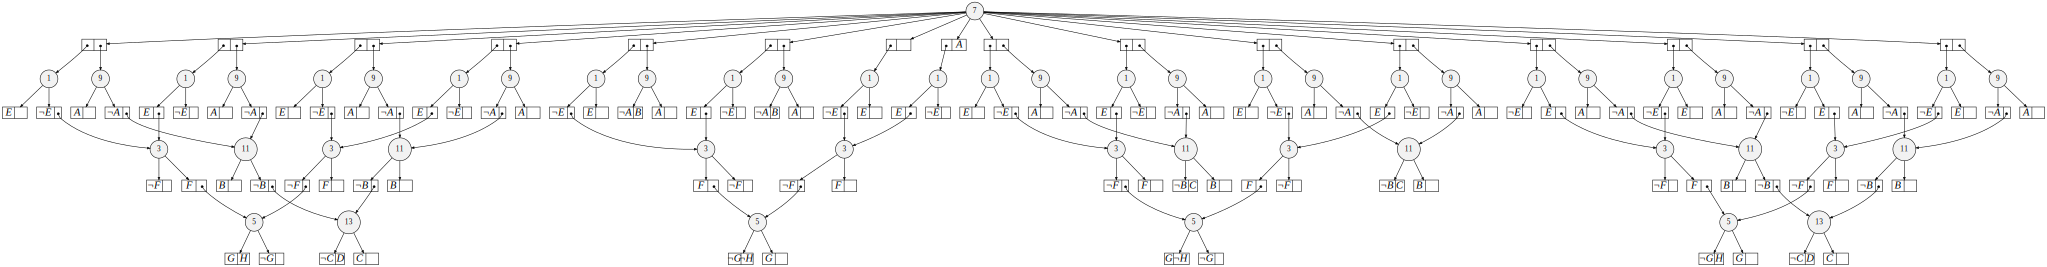

In [14]:
Source(alpha.dot())

In [15]:
alpha.ref()

Minimize the SDD

In [16]:
mgr.minimize()
print(f"Size alpha: {alpha.size()}")

Size alpha: 8


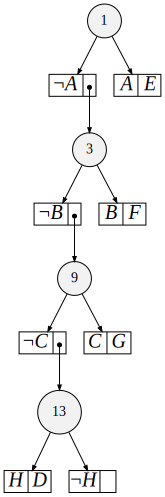

In [17]:
Source(alpha.dot())

Show the new vtree after minimization.

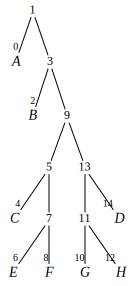

In [18]:
new_vtree = mgr.vtree()
Source(new_vtree.dot())

Augment the SDD

In [19]:
beta = alpha * (mgr.literal(4) + mgr.literal(5))
print(f"Size beta: {beta.size()}")

Size beta: 22


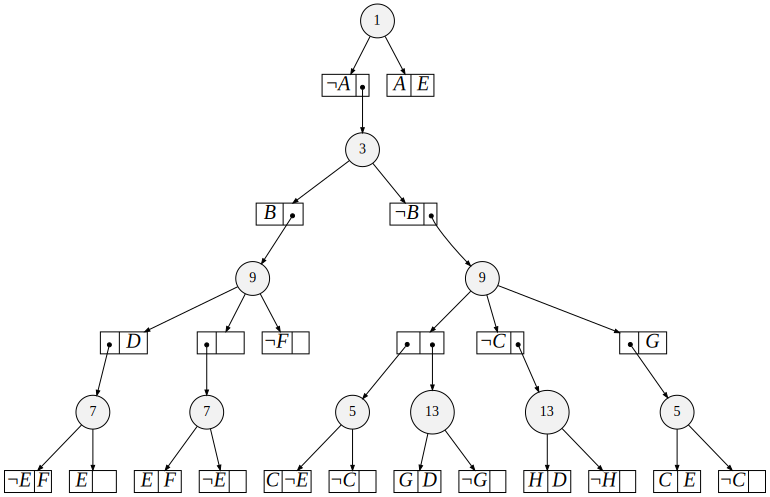

In [20]:
Source(beta.dot())

Perform minimization again on new SDD

In [21]:
beta.ref()

In [22]:
mgr.minimize()
print(f"Size: {beta.size()}")

Size: 21


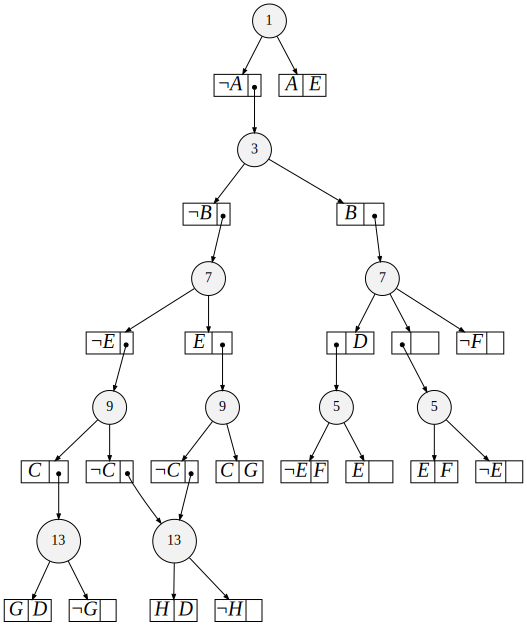

In [23]:
Source(beta.dot())

In [24]:
beta.deref()

### Example: WMC

In [25]:
mgr = SddManager(var_count=4)
a, b, c, d = [mgr.literal(i) for i in range(1,5)]
f = (a*b) + (c*d)

In [26]:
wmc = f.wmc(log_mode=True)
math.exp(wmc.literal_weight(a.literal)), math.exp(wmc.literal_weight(0))

(1.0, 1.0)

In [27]:
w = wmc.propagate()
print(f"Number of models: {int(math.exp(w))}")

Number of models: 6


In [28]:
wmc.set_literal_weight(a.literal, math.log(0.5))
wmc.set_literal_weight(-a.literal, math.log(0.5))

In [29]:
w = wmc.propagate()
print(f"Weighted model count: {math.exp(w)}")

Weighted model count: 3.5


## Conclusion

The `PySDD` package can be downloaded from https://github.com/wannesm/PySDD/. More examples are available in the `examples` directory.